In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch
import torch.nn as nn

In [2]:
class FloodAreaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_list = [f for f in os.listdir(os.path.join(data_dir, 'Image')) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = os.path.join(self.data_dir, 'Image', image_name)
        mask_name = os.path.splitext(image_name)[0] + '.png'
        mask_path = os.path.join(self.data_dir, 'Mask', mask_name)

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
class WaterBodiesDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_list = [f for f in os.listdir(os.path.join(data_dir, 'Images')) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = os.path.join(self.data_dir, 'Images', image_name)
        mask_name = os.path.splitext(image_name)[0] + '.jpg'
        mask_path = os.path.join(self.data_dir, 'Masks', mask_name)

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [21]:
data_dir = 'flooded-area-segmentation/'
dataset = WaterBodiesDataset(data_dir, transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'flooded-area-segmentation/Images'

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)

        self.upconv5 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = conv_block(1024, 512)
        self.upconv6 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = conv_block(512, 256)
        self.upconv7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = conv_block(256, 128)
        self.upconv8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = conv_block(128, 64)

        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(nn.MaxPool2d(kernel_size=2)(x1))
        x3 = self.conv3(nn.MaxPool2d(kernel_size=2)(x2))
        x4 = self.conv4(nn.MaxPool2d(kernel_size=2)(x3))
        x5 = self.conv5(nn.MaxPool2d(kernel_size=2)(x4))

        x6 = torch.cat([x4,self.upconv5(x5)], dim=1)
        x6 = self.conv6(x6)

        x7 = torch.cat([x3,self.upconv6(x6)], dim=1)
        x7 = self.conv7(x7)

        x8 = torch.cat([x2,self.upconv7(x7)], dim=1)
        x8 = self.conv8(x8)

        x9 = torch.cat([x1,self.upconv8(x8)], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)

        return output

class WNet(nn.Module):
    def __init__(self):
        super(WNet,self).__init__()
        
        # First U-Net
        self.unet1 = UNet()
        
        # Second U-Net
        self.unet2 = UNet(in_channels=1)
        
    def forward(self,x):
        
        # Pass input through first U-Net
        unet1_out=self.unet1(x)
        
        # Pass output of first U-Net through second U-Net
        unet2_out=self.unet2(unet1_out)
        
        return unet2_out


In [22]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# set the device to use for computations
device = torch.device("cuda" if use_cuda else "cpu")

# define the model
model = UNet()
model.to(device)

# define the loss function
criterion = nn.BCEWithLogitsLoss()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs to train for
num_epochs = 10

# create a SummaryWriter to log training progress to TensorBoard
writer = SummaryWriter()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # create a progress bar using tqdm
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, data in pbar:
        # get the inputs and labels and move them to the GPU
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # compute the accuracy
        predicted = outputs > 0.5
        total += labels.numel()
        correct += (predicted == labels).sum().item()

        # backward pass
        loss.backward()
        optimizer.step()

        # update the progress bar and print statistics
        running_loss += loss.item()
        pbar.set_description(f'Epoch: {epoch + 1}, Loss: {running_loss / (i + 1):.3f}, Accuracy: {correct / total:.3f}')

    # log the loss and accuracy to TensorBoard
    writer.add_scalar('Loss/train', running_loss / len(dataloader), epoch)
    writer.add_scalar('Accuracy/train', correct / total, epoch)

print('Finished Training')


Epoch: 1, Loss: 0.503, Accuracy: 0.608:  73%|███████▎  | 517/711 [04:02<01:27,  2.21it/s]

In [10]:
class TestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_list = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = os.path.join(self.data_dir, image_name)

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image_name, image

In [11]:
test_data_dir = 'dataset/flooded'
test_dataset = TestDataset(test_data_dir, transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [12]:
# create the output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# set the model to evaluation mode
model.eval()

with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # get the image name and input
        image_name, inputs = data
        inputs = inputs.to(device)

        # forward pass
        outputs = model(inputs)
        predicted = outputs > 0.5

        # save the predicted mask
        mask_name = os.path.join('output', image_name[0])
        Image.fromarray(predicted.squeeze().cpu().numpy()).save(mask_name)

100%|██████████| 461/461 [00:31<00:00, 14.85it/s]


In [13]:
def apply_mask(image, mask):
    # convert the image and mask to numpy arrays
    image = np.array(image)
    mask = np.array(mask)

    # apply the mask to each channel of the image

    masked_image = image.copy()
    masked_image[0, :, :] = image[0, :, :].copy() * mask
    masked_image[1, :, :] = image[1, :, :].copy() * mask
    masked_image[2, :, :] = image[2, :, :].copy() * mask

    # transpose the masked image to have shape (height, width, channels)
    masked_image = np.transpose(masked_image, (1, 2, 0))

    # convert the masked image to uint8
    masked_image = masked_image.astype(np.uint8)

    return masked_image

# create the mask_output directory if it doesn't exist
os.makedirs('mask_output', exist_ok=True)

# create a new FloodTestDataset for the test data
test_data_dir = 'dataset/flooded'
test_dataset = TestDataset(test_data_dir, transform=data_transforms)

# iterate over the test data
for i in tqdm(range(len(test_dataset)), total=len(test_dataset)):
    # get the image name and image
    image_name, image = test_dataset[i]

    # load the predicted mask
    mask_name = os.path.join('output', image_name)
    mask = Image.open(mask_name).convert('L')

    # apply the mask to the image
    masked_image = apply_mask(image, mask)

    # save the masked image
    masked_image_name = os.path.join('mask_output', image_name)
    Image.fromarray(masked_image).save(masked_image_name)


100%|██████████| 461/461 [00:15<00:00, 28.97it/s]


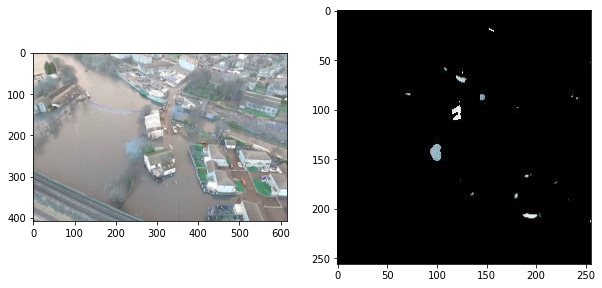

In [20]:
# Show the original image & the masked image (from mask_output folder)

img_name = '5.jpg'
img_path = os.path.join('dataset/flooded/', img_name)
masked_img_path = os.path.join('mask_output/', img_name)

img = Image.open(img_path)
masked_img = Image.open(masked_img_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(masked_img)
plt.show()
